https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/#flights

In [93]:
import getpass
import os
from langchain_core.tools import tool
from langchain_aws import ChatBedrock
import boto3
from langchain_core.prompts import ChatPromptTemplate

os.environ["TAVILY_API_KEY"] = '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'
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = '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'
os.environ["LANGCHAIN_PROJECT"] = "agent-solarpanels-tutorial"

# Tools

### GetEnergySavings

In [94]:
@tool
def compute_savings(monthly_cost: float) -> float:
    """Compute the amount of money that will be saved."""
    def calculate_solar_savings(monthly_cost):
        # Assumptions
        cost_per_kWh = 0.28  # Updated to reflect Belgium's average cost
        cost_per_watt = 1.50  # euros per watt for installation
        sunlight_hours_per_day = 3.5  # Updated for Belgium's average sunlight
        panel_wattage = 350  # watts per panel
        system_lifetime_years = 10  # years for savings calculation
        
        # Step 1: Calculate Monthly Electricity Consumption in kWh
        monthly_consumption_kWh = monthly_cost / cost_per_kWh
        
        # Step 2: Calculate Required System Size in kW
        daily_energy_production = monthly_consumption_kWh / 30
        system_size_kW = daily_energy_production / sunlight_hours_per_day
        
        # Step 3: Calculate the Number of Solar Panels
        number_of_panels = system_size_kW * 1000 / panel_wattage
        
        # Step 4: Calculate Installation Cost
        installation_cost = system_size_kW * 1000 * cost_per_watt
        
        # Step 5: Calculate Annual Savings
        annual_savings = monthly_cost * 12
        
        # Step 6: Calculate Net Savings Over 10 Years
        total_savings_10_years = annual_savings * system_lifetime_years
        net_savings = total_savings_10_years - installation_cost
        
        return {
            "number_of_panels": round(number_of_panels),
            "installation_cost": round(installation_cost, 2),
            "net_savings_10_years": round(net_savings, 2)
        }

    results = calculate_solar_savings(monthly_cost)

    savings_over_10_years = results["net_savings_10_years"]

    return results

# Utilities
Define helper functions to pretty print the messages in the graph while we debug it and to give our tool node error handling (by adding the error to the chat history).

In [95]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# State

In [96]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Agent
Next, define the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [97]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_aws import ChatBedrock
import boto3

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# LLM with function call
def get_bedrock_client(region):
    return boto3.client("bedrock-runtime", region_name=region)

def create_bedrock_llm(client):
    return ChatBedrock(model_id='anthropic.claude-3-sonnet-20240229-v1:0', client=client, model_kwargs={'temperature': 0}, region_name='us-east-1')

llm = create_bedrock_llm(get_bedrock_client(region = 'us-east-1'))

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            '''You are a helpful customer support assistant for Solar Panels Belgium.
            You should get the following information from them:
            - monthly electricity cost
            If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

            After you are able to discern all the information, call the relevant tool.
            ''',
        ),
        ("placeholder", "{messages}"),
    ]
)

part_1_tools = [
    TavilySearchResults(max_results=1),
    compute_savings
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

# Define Graph

In [98]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

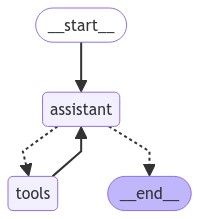

In [99]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [103]:
# import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    'hey',
    'can you calculate my energy saving',
    "my montly cost is $100, what will i save"
]

# Update with the backup file so we can restart from the original place in each section
# shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        # "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

hey
content='Hello! How can I assist you today with solar panels or related services from Solar Panels Belgium?' additional_kwargs={'usage': {'prompt_tokens': 401, 'completion_tokens': 23, 'total_tokens': 424}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 401, 'completion_tokens': 23, 'total_tokens': 424}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-9aef91e6-0d9c-4f97-8693-f7723648df84-0' usage_metadata={'input_tokens': 401, 'output_tokens': 23, 'total_tokens': 424}
================================== Ai Message ==================================

Hello! How can I assist you today with solar panels or related services from Solar Panels Belgium?
================================ Human Message =================================

can you calculate my energy saving
content="Sure, I'd b